# Inverse graphics via optimization with differentiable graphics

We will start with installing the neccesary packages: mitsuba for differentiable rendering and numpy for numerical processing. 

We will install `mitsuba` and `numpy` using `Conda.jl`. The following snippet will create a local environment that will allow you to install things on the Apptainer container (and on your own computer). 

In [2]:
using Pkg
Pkg.activate("psyc261")
Pkg.add("Conda")
using Conda
Conda.add("numpy")

  Activating project at `~/Algorithms-of-the-Mind/lectures/lecture-13/psyc261`
   Resolving package versions...
  No Changes to `~/Algorithms-of-the-Mind/lectures/lecture-13/psyc261/Project.toml`
  No Changes to `~/Algorithms-of-the-Mind/lectures/lecture-13/psyc261/Manifest.toml`
[ Info: Running `conda install -y numpy` in root environment


Channels:
 - conda-forge
Platform: linux-64
Solving environment: ...working... done

# All requested packages already installed.





==> WARNING: A newer version of conda exists. <==
    current version: 25.7.0
    latest version: 25.9.0

Please update conda by running

    $ conda update -n base -c conda-forge conda




In [3]:
# need this for installing mitsuba...

run(`conda config --set pip_interop_enabled true`)
run(`pip install mitsuba`)

Defaulting to user installation because normal site-packages is not writeable


Process(`pip install mitsuba`, ProcessExited(0))

In [4]:
Pkg.add(["Distributions", "ProgressMeter", "Gen", "Plots", "Parameters", "PyCall"])

   Resolving package versions...
  No Changes to `~/Algorithms-of-the-Mind/lectures/lecture-13/psyc261/Project.toml`
  No Changes to `~/Algorithms-of-the-Mind/lectures/lecture-13/psyc261/Manifest.toml`


In [5]:
using Pkg
using Distributions
using ProgressMeter
using Gen, Plots
using Parameters
using PyCall
np = pyimport("numpy")
;

# Part 0: The task

The task in this lab is to an optimization routine for inverse graphics via a differentiable generative process.

# Part 1: Compute graphics & `mitsuba`
## Mini introduction to computer graphics

Computer graphics are concerned with algorithmically tractable methods for representing 3D scenes (static or dynamic) and syntesizing realistic (or non-realistic) imagery based off of these scenes. Rendering is the process of synthesizing an image from a 3D (or a 2D) scene via a computer program. We will refer to such computer programs as *rendering engines*.

<img src="./images/render.png" alt="" width="400"/>

In a rendering engine, a 3D scene is defined by 4 basic ingredients:

1. Objects (e.g., 3D shapes and surfaces)
2. Optical material properties (how the surface of an object is supposed to reflect light; e.g., glass-like, diffuse, opaque, transparent, shiny, etc.)
3. Lights
4. Sensors or camera

This course is obviously not about developing rendering engines -- [see the relevant courses](https://courses.yale.edu/?keyword=computer%20graphics) offered by the Department of Computer Science and numerous resources online. Instead, we will use existing rendering engines, embedding them within probabilistic models.

To create a 3D scene and generate an image, you need to provide the rendering engine (`mitsuba` in our case) with each of the four ingredients described earlier (objects, optical material properties, lights, and sensors/cameras).

## Mini introduction to Mitsuba3

The field of computer graphics has developed many algorithms for realistic image synthesis. At the highest level, rendering engines can be categorized into:
1. real-time renderers (rasterization renderers, etc.), or
2. physically-based renderers (ray-traced renderers, etc.).

`mitsuba` is a **physically-based renderer**. This means that it sends "rays" from the camera out into the scene and tracks where and how they intersect light sources. These rays are then integrated to figure out what color to paint on each pixel in an image. (Here's an informative [tutorial on ray tracing](https://youtu.be/gsZiJeaMO48). _This is not relevant material for PSYC 261._)

<img src="./images/raytracing.png" alt="" width="400"/>

Like other rendering engines, we need to input a scene to `mitsuba` (lights, optical materials, objects, sensory). This can be done using XML or a Python dictionary. We provide examples of both below. 

In this course, we chose to work with mitsuba3 because it is open source software, and has some exciting attributes (many of which we will not get into in this lab), notably, differentiable rendering capabilities. Additionally, in ongoing research in Ilker's lab, `mitsuba` has proven to be dependable for its numerical stability and customizability for probabilistic inference. 

Please see the [tutorials](https://www.youtube.com/watch?v=9Ja9buZx0Cs&list=PLI9y-85z_Po6da-pyTNGTns2n4fhpbLe5) and [documentation](https://mitsuba.readthedocs.io/en/stable/) on Mitsuba3's [official website](https://www.mitsuba-renderer.org/) for more. 

**Notice that `mitsuba` is a Python package**; to use it we rely on the `PyCall` package of Julia, which provides a native interface to python code. You can familiarize yourself with PyCall [here](https://github.com/JuliaPy/PyCall.jl#usage).

# Part 2: Using `mitsuba`

## Getting started with `mitsuba`

In this tutorial, we will learn about how to load a scene and render it. Mitsuba3 gives a lot of fun flexibility, especially in terms of rendering. 

Before we start, let's execute our very first command with mitsuba3.

In [6]:
# import mitsuba and drjit (mitsuba's differentiation engine) using pycall
dr = pyimport("drjit")
mi = pyimport("mitsuba")

# different rendering modes of mitsuba 
mi.variants()
# we set llvm_ad_rgb which enables autodiff (ad)
mi.set_variant("llvm_ad_rgb")

Now the output of this function `mi.variants()` tells us that mitsuba3 can render a scene in 4 different modes. We will be using `llvm_ad_rgb` to access to gradients of rendering. 

### Loading and rendering a scene (objects, lights, materials, sensors) in `mitsuba`

Then, we will load a scene with two spheres in a room with differently colored walls. We will then render it.

The scene description will be loaded from an xml file. Run this code and review its output to appreciate how it defines each of the four kinds of elements we are talking about: shapes, lights, optical materials (jargon name: BSDFs), and sensors.

`OBJMesh` are the walls, `Sphere` is a shape; things like `SmoothDiffuse` are optical material properties; `emitter`s are lights; and `PerspectiveCamera` is the sensor. Notice how each entry has certain properties: For example an object needs to define where it is in the world (`to_world`) and its optical material property.

You can also review the xml file itself, `cbox-generic.xml`, to further appreciate what goes into a scene.

In [7]:
scene = @pycall mi.load_file("./cbox_generic.xml", res=64, integrator="prb")::PyObject

PyObject Scene[
  children = [
    PRBIntegrator[max_depth = 6, rr_depth = 5],
    PerspectiveCamera[
      x_fov = [39.3077],
      near_clip = 0.001,
      far_clip = 100,
      film = HDRFilm[
        size = [64, 64],
        crop_size = [64, 64],
        crop_offset = [0, 0],
        sample_border = 0,
        compensate = 0,
        filter = TentFilter[radius=1.000000],
        file_format = OpenEXR,
        pixel_format = rgb,
        component_format = float32,
      ],
      sampler = IndependentSampler[
        base_seed = 0
        sample_count = 16
        samples_per_wavefront = 1
        wavefront_size = 0
      ],
      resolution = [64, 64],
      shutter_open = 0,
      shutter_open_time = 0,
      to_world = [[-1, 0, 0, 0],
                  [0, 1, 0, 0],
                  [0, 0, -1, 4],
                  [0, 0, 0, 1]]
    ],
    SmoothDiffuse[
      reflectance = SRGBReflectanceSpectrum[
        value = [[0.85, 0.85, 0.85]]
      ]
    ],
    SmoothDiffuse[
      refl

Below, we have four helper functions, implemented as Python code, to manipulate some aspects of a mitsuba data structure, called `params`. This data structure is dictionary-like, but PyCall's translator does not handle it well, so we'll keep the manipulation of `params` within Python. 

The function `update_scene` updates something in the scene (e.g., where an object is, or how big it is, etc.). This is done first updating the scene `params` and then calling `params.update()` to propagate those changes back into the scene itself.

The function `update_scene_opt` updates the `params` and the scene based on the parameters that are being optimized. These parameters are stored in another dictionary called `opt`.

The function `opt_clip` simply clips the values of the parameters in the `opt` to their allowed ranges.

And finally the function `add_to_opt` adds a new parameter to the set of parameters to be optimized.

In [8]:
py"""
import mitsuba as mi
import drjit as dr

def update_scene(scene, key, val):
    params = mi.traverse(scene)
    params[key] = val
    params.update()

def update_scene_opt(params, key, opt, key2):
    params[key] = mi.Transform4f().translate(mi.Vector3f(0.5, -0.75, -0.2)).scale(mi.Vector3f([opt[key2], opt[key2], opt[key2]]))
    params.update()

def opt_clip(opt, key):
    opt[key] = dr.clip(opt[key], 0.01, 1.0)


def add_to_opt(opt, val, key):
    opt[key] = val

"""

Recall that we mentioned `mitsuba` is a physically-based renderer that estimates the color of each pixel using ray tracing. Ray-tracing is a computationally costly operation and `mitsuba` allows you to make a tradeoff that suits your goals. 

The parameter `spp`, which stands for samples per pixel and is input to the `mi.render` function below, is essentially the number of rays cast to compute the color per pixel. The choice of spp reflects a tradeoff: The greater the `spp`, the higher the quality and realism of our render is, with the expense of higher computational cost. You can reduce `spp` to obtain lower quality renders, which is often acceptable, especially for characterizing an approximate process of rendering that may be implemented in the mind and brain. (Regardless, this will be handy when we are doing probabilistic inference later on.) 

In [9]:
# set spp to 12 -- play with different values
spp = 128

# render the scene
image_ref = @pycall mi.render(scene, spp=spp)::PyObject
# get the bitmap, which Jupyter notebook displays inline!
bitmap_ref = @pycall mi.Bitmap(image_ref).convert(srgb_gamma=true)::PyObject

PyObject Bitmap[
  pixel_format = rgb,
  component_format = float32,
  size = [64, 64],
  srgb_gamma = 1,
  struct = Struct<12>[
    float32 R; // @0, gamma, premultiplied alpha
    float32 G; // @4, gamma, premultiplied alpha
    float32 B; // @8, gamma, premultiplied alpha
  ],
  data = [ 48 KiB of image data ]
]

Wow! How cool is that?! You just rendered a nice scene with umm spheres in it. Yay for you! 

### Transformations of scene elements using `mitsuba`

Now a critical component of computer graphics is to manipulate the scene -- including adding, deleting, changing, moving (translating) and scaling the things in a scene. Here we will learn how we can translate and scale one of the cuboids in the scene. 

We will transform the sphere on the right -- `right-object` -- using by updating the scene parameters stored in `params`. (Notice that this is less painful than the lab 5 approach.)

In [10]:
key = "right-object.to_world"
# create a new transformation
translation = [0.5, -0.75, 0.7]
scale = 0.1 
transform = mi.Transform4f.translate(translation).scale(scale)
py"update_scene"(scene, key, transform)

We kept its original translation 

Translation: `[0.5, -0.75, -0.2]`

but changed its scale from .5 to .1.

Now let's reload this updated dictionary into our scene and render it.

In [11]:
image = @pycall mi.render(scene, spp=spp)::PyObject
# get the bitmap, which Jupyter notebook displays inline!
bitmap = @pycall mi.util.convert_to_bitmap(image)::PyObject

PyObject Bitmap[
  pixel_format = rgb,
  component_format = uint8,
  size = [64, 64],
  srgb_gamma = 1,
  struct = Struct<3>[
    uint8 R; // @0, normalized, gamma, premultiplied alpha
    uint8 G; // @1, normalized, gamma, premultiplied alpha
    uint8 B; // @2, normalized, gamma, premultiplied alpha
  ],
  data = [ 12 KiB of image data ]
]

Notice how the right object became smaller than it was before and came closer to the sensor.

Okay now let's do some *inverse* graphics.

# Part 3: Inverse graphics & modeling

## Inverse graphics

We start by writing a Julia struct to hold the state of the scene -- including the scene and the `spp`.

In [12]:
# the with_kw macro comes from the Parameters package 
# and is a handy macro for having default values to certain entries in a Julia struct.
@with_kw struct ModelParams
    scene = @pycall mi.load_file("./cbox_generic.xml", res=64, integrator="prb")::PyObject
    spp::Int32 = 16
end;

We will also define a helper function for rendering a bitmap image (that can be visualized within jupyter notebooks)

In [13]:
function render_bitmap(modelparams)
    image = @pycall mi.render(modelparams.scene, spp=modelparams.spp)::PyObject
    bitmap = @pycall mi.util.convert_to_bitmap(image)::PyObject
    return bitmap
end
;

### Optimization routine

The following code implements an optimization routine for the scale of the right object, by defining a latent variable `s` and optimizing it in the loop.

The call `dr.backward(loss)` evaluates and backpropagates all the relevant gradients we discussed, 

- the gradient of the likelihood wrt the synthesized image
- the gradient of the synthesized image wrt latents

Thus, we have a gradient descent routine for optimizing the latent scale parameter of the right object. 

Notice that we're optimizing under a rougher, noisier spp parameter of 16. Try making it 128 and notice how much it slows down.

In [14]:
modelparams = ModelParams()
params = mi.traverse(modelparams.scene)
key = "right-object.to_world"

opt = mi.ad.Adam(lr=0.01)
#t = mi.Vector3f(0, 0, 0)
#py"add_to_opt"(opt, t, "translation")
s = mi.Float64(.3)

py"add_to_opt"(opt, s, "scale")
py"update_scene_opt"(params, key, opt, "scale")

K = 100
    
scores = Vector{Float64}(undef, K)
@showprogress for i in 1:K

    image = mi.render(modelparams.scene, params, spp=16)

    loss = dr.mean(dr.square(image - image_ref))
    
    dr.backward(loss)

    opt.step() 
    py"opt_clip"(opt, "scale")
    
    py"update_scene_opt"(params, key, opt, "scale")
    
    scores[i] = convert(Float64, dr.slice(loss).item())
end;


Progress: 100%|█████████████████████████████████████████| Time: 0:00:21


Now, how do I know if my optimization routine worked? 

Let's first visualize to see if our scores improved over iterations (x-axis: iterations; y-axis: loss).

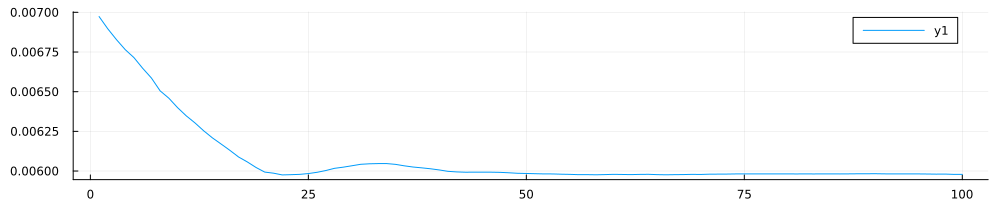

In [15]:
plot(scores, size = (1000, 200))

Alright this should look good. Try to reason about how often proposals are accepted by the step-wise changes in the loglikelihood scores over iterations.

Now let's find out what our inferred scene looks like at the end of the procedure:

In [16]:
render_bitmap(modelparams)

PyObject Bitmap[
  pixel_format = rgb,
  component_format = uint8,
  size = [64, 64],
  srgb_gamma = 1,
  struct = Struct<3>[
    uint8 R; // @0, normalized, gamma, premultiplied alpha
    uint8 G; // @1, normalized, gamma, premultiplied alpha
    uint8 B; // @2, normalized, gamma, premultiplied alpha
  ],
  data = [ 12 KiB of image data ]
]

Compare the image that your model synthesized to what the observation was like from above. Did the inference procedure work reasonably well? Try changing the number of iterations. 

## Taking stock:

Notice what we have accomplished: The result of the optimization procedure is not just a reconstructed image -- rather, it is a causal explanation that goes far beyond what was in the image: a 3D scene that we can re-light, re-pose, and manipulate. The result of inference